In [1]:
import os
import argparse
import datetime as dt
import numpy as np
import torch as th
import torch.nn as thnn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.cuda.amp import autocast, GradScaler
from pytorch_toolbelt import losses as L

import dgl
from dgl.dataloading.neighbor import MultiLayerNeighborSampler
from dgl.dataloading.pytorch import NodeDataLoader

from utils import load_dgl_graph

Using backend: pytorch


In [2]:
graph, labels, train_nid, val_nid, test_nid, node_feat = load_dgl_graph('../../MAXPdata')
graph.ndata['feature'] = node_feat

################ Graph info: ###############
Graph(num_nodes=3655452, num_edges=29168650,
      ndata_schemes={}
      edata_schemes={})
################ Label info: ################
Total labels (including not labeled): 3655452
               Training label number: 939963
             Validation label number: 104454
                   Test label number: 592391
################ Feature info: ###############
Node's feature shape:torch.Size([3655452, 300])


In [3]:
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(5)
train_dataloader = NodeDataLoader(graph,
                                    train_nid,
                                    sampler,
                                    batch_size=3,
                                    shuffle=True,
                                    drop_last=False,
                                    num_workers=0,
                                    )

In [44]:
for step, (input_nodes, seeds, blocks) in enumerate(train_dataloader):
    if step==2:
        g=blocks
        subg = dgl.in_subgraph(graph, seeds)
        print("step:", step)
        print("seeds:", seeds)
        break

step: 2
seeds: tensor([1372502, 2342634, 1193582])


In [46]:
# a=blocks[1].ndata[dgl.NID]['_N']
# b=blocks[0].ndata[dgl.NID]['_N']
# c=th.cat([a,b],0)

c = th.Tensor([]).to(th.int32)
for block in blocks:
    c=th.cat([c, block.srcdata[dgl.NID]],0)
    # print(block)
    # print(block.srcdata[dgl.NID])
sg = dgl.node_subgraph(graph, c)
sg

Graph(num_nodes=642, num_edges=936,
      ndata_schemes={'feature': Scheme(shape=(300,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [6]:
which_block = 1
src = g[which_block].edges()[0]
dst = g[which_block].edges()[1]

print(g[which_block])
print(src)
print(dst)
print(g[which_block].srcdata[dgl.NID])
print(g[which_block].dstdata[dgl.NID])

Block(num_src_nodes=13, num_dst_nodes=9, num_edges=11)
tensor([ 3,  4,  5,  6,  7,  8,  9,  5, 10, 11, 12])
tensor([1, 1, 3, 5, 5, 5, 6, 6, 7, 8, 8])
tensor([1878431,  939332, 1875357, 2013265, 1368618, 3099675, 3353471, 3550293,
        3456768, 3481510, 3444191, 3402132, 3456361])
tensor([1878431,  939332, 1875357, 2013265, 1368618, 3099675, 3353471, 3550293,
        3456768])


In [7]:
new_g = dgl.graph((src, dst))
print(new_g.nodes())
print(g[which_block].nodes('_N'))
print(new_g)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])
Graph(num_nodes=13, num_edges=11,
      ndata_schemes={}
      edata_schemes={})


In [8]:
g = dgl.graph(([0, 0, 1, 2, 3, 4], [2, 1, 2, 3, 4, 0]))  # 5-node cycle
# sg = dgl.in_subgraph(g, [2])
sg = dgl.node_subgraph(g, [0, 0, 0, 0, 0, 0])
sg.edges()
# sg.ndata[dgl.NID]  # original node IDs
# sg.edata[dgl.EID]  # original edge IDs

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))

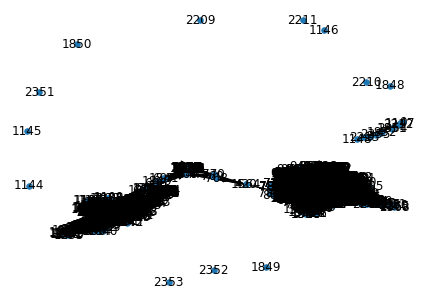

In [19]:
import networkx as nx
import dgl
import matplotlib.pyplot as plt

# plt.subplot(121)#在画布上绘制子图，第一个‘1’代表共有一行，‘2’代表有两列，‘1’代表该图片将位于1号位置
# nx.draw(g.to_networkx(), with_labels=1, node_size=30, font_size=12)

# plt.subplot(122)#在画布上绘制子图，第一个‘1’代表共有一行，‘2’代表有两列，‘1’代表该图片将位于1号位置
nx.draw(sg.to_networkx(), with_labels=1, node_size=30, font_size=12)

plt.show()